# Tutorial: Model Training / Inference based on MixedDatasets

# 1. Prepare enviroment and setup your own Object Detection tool.

In [ ]:
# 1. Configure ENVS
%load_ext autoreload
%autoreload 2

## 1.1 check gcc, g++ and cuda
!gcc --version
!g++ --version
!nvcc --version

import os
ROOT_PATH = os.path.abspath("./")

## 1.2 Clone our repo
!git clone https://github.com/jichengyuan/mmdetectionCust.git

## 1.3 install mmcv-full and other dependencies
# You may need to restart your runtime after this cell, to let your installation take effect.
%cd mmdetectionCust/
!python -m pip install cython funcy && python -m pip --no-cache-dir install -r requirements.txt
!python -m pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu102/torch1.9.0/index.html
!python setup.py develop
%cd ..

## 1.4 download a pretrained model if desired
path_to_pth = ROOT_PATH+'/mmdetectionCust/pths/focs/'
os.makedirs(path_to_pth, exist_ok=True)
%cd mmdetectionCust/
!wget -P $path_to_pth https://openmmlab.oss-cn-hangzhou.aliyuncs.com/mmdetection/v2.0/fcos/fcos_r50_caffe_fpn_gn-head_1x_coco/fcos_r50_caffe_fpn_gn-head_1x_coco-821213aa.pth
%cd ..





# 2 MixedDataset with Vision KG: Querying, Training and Testing

## 2.1 Query a MixedDataset

In [ ]:
# install our vision utils
!python -m pip install git+https://github.com/cqels/vision.git --force


In [ ]:
# import SemkgAPI
import json
from vision_utils import semkg_api, data
from os.path import join as opj
from utils import dataset_split, check_instances_categories, check_download_images


query_string='''#Give me the images containing person and cat
prefix cv:<http://vision.semkg.org/onto/v0.1/>
SELECT DISTINCT ?image
WHERE {
    ?ann1 a cv:Annotation.
    ?ann1 cv:isAnnotationOfImage ?image.
    ?ann1 cv:hasAnnotatedObject ?obj1.
    ?obj1 cv:hasLabel "person".
    ?ann2 a cv:Annotation.
    ?ann2 cv:isAnnotationOfImage ?image.
    ?ann2 cv:hasAnnotatedObject ?obj2.
    ?obj2 cv:hasLabel "cat".
    ?image cv:hasLocalPath ?localPath.
}
LIMIT 20'''

result=semkg_api.query(query_string)

ROOT_PATH = os.path.abspath('./')
json_f_name = 'test_query_api_image.json'
path_to_anno_mixedDatasets = opj(ROOT_PATH, 'testData/mixedDatasets/')
os.makedirs(path_to_anno_mixedDatasets, exist_ok=True)
path_to_anno = opj(path_to_anno_mixedDatasets, json_f_name)

with open(path_to_anno, "w") as f:
    json.dump(result,f)



In [ ]:
# Using vision utils to check and download missing data
check_download_images(result["images"])
categories = [category['name'] for category in result['categories']]
number_of_categories = len(categories)

In [ ]:
## users could turn to downloaded above images by themselves or remove those
## images from annotations files

In [ ]:
# analysis of extacted mixed Dataset
# from utils import images_categories_distribution

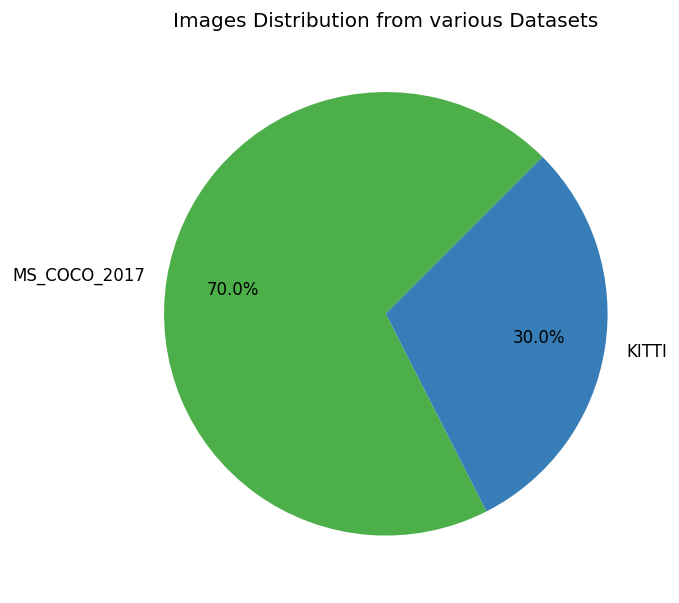




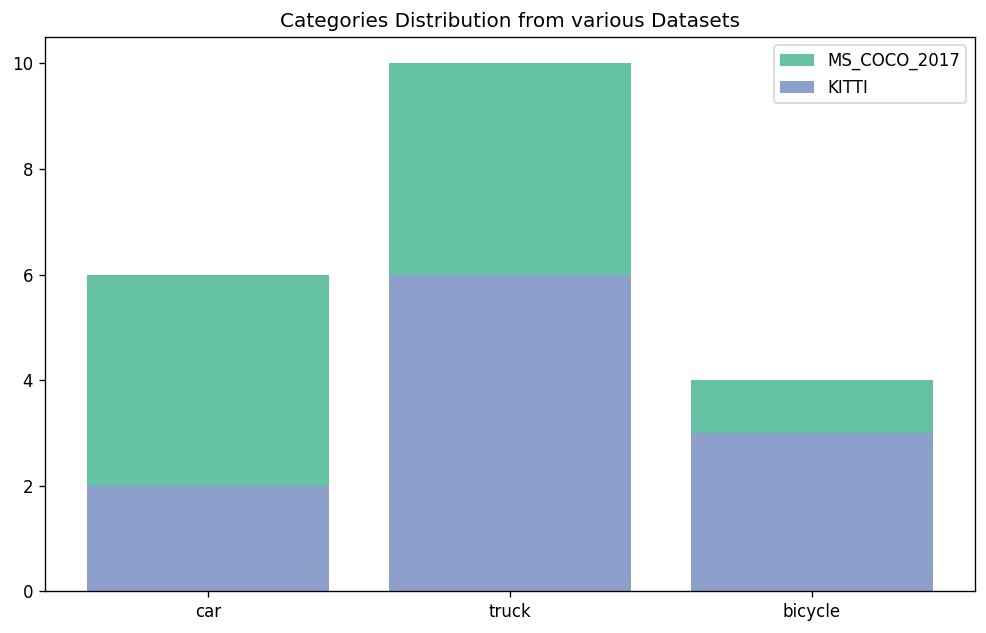

## 2.2 Perform Training on your chosen Object Detection tool.

In [ ]:
## Split the quried MixedDatasets and check the #instances per category
path_to_train_val = opj(path_to_anno_mixedDatasets,'train_val_set.json')
path_to_train = opj(path_to_anno_mixedDatasets,'train_set.json')
path_to_val = opj(path_to_anno_mixedDatasets,'val_set.json')
path_to_test = opj(path_to_anno_mixedDatasets,'test_set.json')
ratio = 0.8

dataset_split(path_to_anno, path_to_train_val, path_to_test, ratio)
dataset_split(path_to_train_val, path_to_train, path_to_val, ratio)

## Set paths for config and work-dir
path_to_config = 'configs/fcos/fcos_r50_caffe_fpn_gn-head_1x_mixedDataset_loadFromSeparatedFile.py'
path_to_work_dir = 'training_logs_example/fcos_coco_format_anno_example/'
path_to_pretrained_weights = 'pths/focs/fcos_r50_caffe_fpn_gn-head_1x_coco-821213aa.pth'

## Training on the MixedDataset
%run tools/train.py \
{path_to_config} \
--work-dir {path_to_work_dir} \
--cfg-options model.bbox_head.num_classes={number_of_categories} \
data.train.ann_file={path_to_anno} \
data.val.ann_file={path_to_anno} \
runner.max_epochs=4 \
data.samples_per_gpu=1 \
load_from={path_to_pretrained_weights} \
data.train.classes="$categories" \
data.val.classes="$categories"

## Verify the checkpoint file.
checkpoint_file = os.path.join(path_to_work_dir, "latest.pth")
assert os.path.isfile(checkpoint_file), '{} not exist'.format(checkpoint_file)
checkpoint_file = os.path.abspath(checkpoint_file)
output_pkl = os.path.join(path_to_work_dir, 'result_test.pkl')

## Evaluate the trained model on the MixedDataset
%run tools/test.py \
{path_to_config} \
{checkpoint_file} \
--work-dir {path_to_work_dir} \
--out {output_pkl} \
--cfg-options data.test.ann_file={path_to_anno} \
model.bbox_head.num_classes={number_of_categories} \
data.samples_per_gpu=1 \
data.test.classes="$categories" \
--eval bbox \
--show